In [1]:
from pathlib import Path
import torch
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from datasets.animal_dataset import AnimalDataset

from models.vgg16 import VGG16

from config import DATA_FOLDER

import matplotlib.pyplot as plt

from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassF1Score

In [2]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [3]:
checkpoint_path = "../model.pth"
classes = [
    "cane",
    "cavallo",
    "elefante",
    "farfalla",
    "gallina",
    "gatto",
    "mucca",
    "pecora",
    "ragno",
    "scoiattolo",
]
num_classes = len(classes)

data_path = Path("..") / DATA_FOLDER
test_annotations_path = data_path / 'test.csv'
test_images_folder = data_path / 'images/'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

target_transform = None

test_set = AnimalDataset(test_annotations_path, test_images_folder, transform, target_transform)
test_loader = DataLoader(test_set, batch_size=64, drop_last=True)

In [5]:
# load model
model = VGG16(num_classes=num_classes).to(device)

if Path(checkpoint_path).exists():
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])

In [6]:
cm_matrix = MulticlassConfusionMatrix(num_classes=num_classes)
f1 = MulticlassF1Score(num_classes).to(device)

preds = []
labels = []

# inference on new images
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        pred_class = torch.argmax(torch.softmax(pred, dim=1), dim=1)

        preds.append(pred_class.cpu())
        labels.append(y.cpu())

        f1.update(pred, y)

cm_matrix(torch.Tensor(np.asarray(preds)), torch.Tensor(np.asarray(labels)))
f1 = f1.compute()


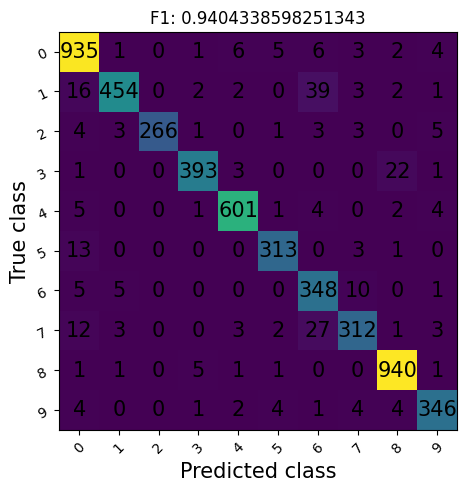

In [7]:
fig_, ax_ = cm_matrix.plot()
plt.title('F1: {}'.format(f1))
plt.show()